In [1]:
import re
import os
import pymorphy2
import pandas as pd
import numpy as np
import pyLDAvis
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from gensim.models import *
from gensim import corpora
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
import nltk
%matplotlib inline

/usr/lib/python3/dist-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
data_path = r'/media/dmitriy/Disk/Downloads/ai_nlp_hw_data/hw_4/'

In [3]:
positive = pd.read_csv(os.path.join(data_path, r'positive.csv'), sep=';', encoding='utf8', header=None)
positive = positive.rename(columns={3:'text'})

In [4]:
negative = pd.read_csv(os.path.join(data_path, r'negative.csv'), sep=';', encoding='utf8', header=None)
negative = negative.rename(columns={3:'text'})

In [5]:
df = pd.concat([positive, negative], ignore_index=True)

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dmitriy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
morph = pymorphy2.MorphAnalyzer()

/home/dmitriy/.local/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/dmitriy/.local/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/dmitriy/.local/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/home/dmitriy/.local/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspe

In [8]:
words_regex = re.compile('\w+')


def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')


def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords
            and w.isalpha()]


def preprocess(text):
    return (lemmatize(find_words(text)))

<>:1: DeprecationWarning: invalid escape sequence '\w'
<>:1: DeprecationWarning: invalid escape sequence '\w'
/tmp/ipykernel_41369/159252999.py:1: DeprecationWarning: invalid escape sequence '\w'
  words_regex = re.compile('\w+')


In [9]:
print(df.text.iloc[7], preprocess(df.text.iloc[7]))

RT @veregijytaqo: У тебя есть ухажёр? Нет - мои уши не кто не жрёт :D ['veregijytaqo', 'ухажёр', 'ухо', 'жрать']


In [10]:
data = df.sample(100000)

In [11]:
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
preprocessed_text2 = data['text'].progress_apply(lambda x: preprocess(str(x)))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [13]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [14]:
data['text'] = preprocessed_text
data.sample(3)

,0,1,2,text,4,5,6,7,8,9,10,11
32398,409748662927912960,1386526668,Alinysik_17,"[наслаждаться, момент, блин, круто, носить, бр...",1,0,0,0,763,16,20,1
216826,423635334745059328,1389837509,MrCosmoKot,"[чувствовать, будущий, friend, зона, твитсдобром]",-1,0,0,0,60,4443,7,0
108267,411163690092601344,1386864037,MKozhina,"[stepanbikerpro, nastuynlalala, poliktorsunova...",1,0,0,0,2065,77,58,1


In [15]:
dictionary = corpora.Dictionary(data['text'])
dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None)
dictionary.save('tweets.dict')

In [16]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('tweets.model', corpus)

In [17]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2)

In [18]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.126*"всё" + 0.020*"понять" + 0.019*"работать" + 0.015*"вечер" + 0.014*"жаль" + 0.013*"ахах" + 0.013*"таки" + 0.013*"ребёнок" + 0.013*"минута" + 0.012*"месяц"'),
 (1,
  '0.078*"мочь" + 0.050*"почему" + 0.041*"делать" + 0.041*"сидеть" + 0.039*"дом" + 0.036*"который" + 0.025*"написать" + 0.021*"хотя" + 0.019*"плохо" + 0.018*"понимать"'),
 (2,
  '0.100*"день" + 0.062*"очень" + 0.044*"любить" + 0.032*"большой" + 0.027*"первый" + 0.024*"дело" + 0.023*"мама" + 0.021*"твой" + 0.020*"неделя" + 0.019*"забыть"'),
 (3,
  '0.163*"это" + 0.074*"весь" + 0.033*"сказать" + 0.031*"говорить" + 0.027*"идти" + 0.026*"школа" + 0.019*"видеть" + 0.012*"скучать" + 0.012*"пара" + 0.011*"увидеть"'),
 (4,
  '0.072*"сегодня" + 0.067*"просто" + 0.059*"знать" + 0.022*"работа" + 0.021*"найти" + 0.020*"посмотреть" + 0.017*"дать" + 0.017*"лента" + 0.016*"наверное" + 0.015*"рука"'),
 (5,
  '0.245*"http" + 0.043*"новый" + 0.042*"год" + 0.033*"друг" + 0.025*"самый" + 0.024*"утро" + 0.018*"читать" + 0.016*"каждый

In [24]:
# %time
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

In [20]:
print(lda.log_perplexity(corpus))

-8.662099349025652


In [21]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.0001730242985318011


In [22]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.21461534866777035


  0%|          | 0/3 [00:00<?, ?it/s]

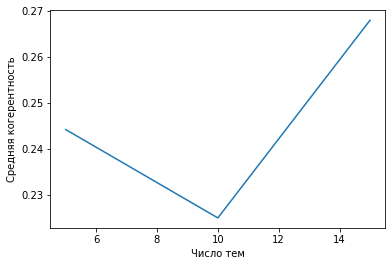

In [23]:
topics_list = [5, 10, 15]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()